In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
import numpy as np
import pandas as pd

In [15]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [21]:
# Calculate the date 1 year ago from the last data point in the database
one_yr_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Design a query to retrieve the last 12 months of precipitation data and plot the results
measurement_12 = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= one_yr_ago).order_by(Measurement.date.desc()).all()
# for measure in measurement_12:
#     print(measure.date, measure.prcp)

# Perform a query to retrieve the data and precipitation scores
df = pd.DataFrame(measurement_12[:2230], columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True )


# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date
result = df.sort_values(by='Date', ascending=False)
result.head(10)
# Use Pandas Plotting with Matplotlib to plot the data



,Precipitation
Date,
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-23,0.00
2017-08-22,0.00
2017-08-22,0.00
2017-08-22,0.50
2017-08-21,0.00
2017-08-21,0.02


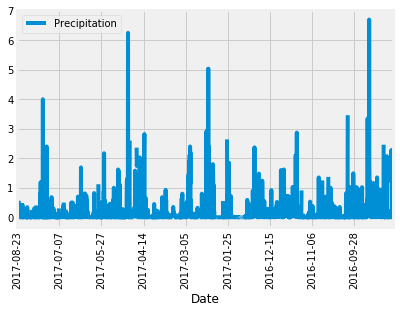

In [24]:
# ax = df.iloc[:20:-1].plot(kind='bar', title ='Precipitation', figsize=(15, 10), legend=True, fontsize=12)
# ax.set_xlabel("Date", fontsize=12)
# ax.set_ylabel("Precipitation", fontsize=12)
# plt.show()

result.plot(rot=90)

![precipitation](Images/precipitation.png)

In [33]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [81]:
# Design a query to show how many stations are available in this dataset?
station_no = session.query(Measurement,Station).filter(Measurement.station == Station.station).all()
# station_count =station.count(station.station) 
station_count = []
for stn in station_no:
    (mt,st) = stn
    station_count.append(st.station)

    
len(set(station_count))

9

In [91]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Counter(station_count)

Counter({'USC00519397': 2724,
         'USC00513117': 2709,
         'USC00514830': 2202,
         'USC00517948': 1372,
         'USC00518838': 511,
         'USC00519523': 2669,
         'USC00519281': 2772,
         'USC00511918': 1979,
         'USC00516128': 2612})

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_q = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

station_q

[(54.0, 85.0, 71.66378066378067)]

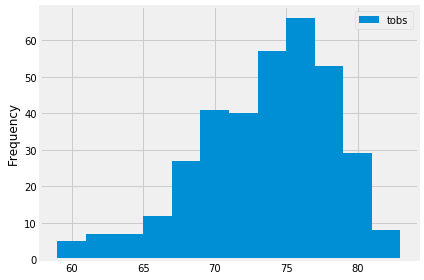

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
import datetime as dt
from pandas.plotting import table
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()

![precipitation](Images/station-histogram.png)

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
import datetime as dt

prev_year_start = dt.date(2018, 1, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 1, 7) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

62.0 68.36585365853658 74.0


C:\Users\bwaiharo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


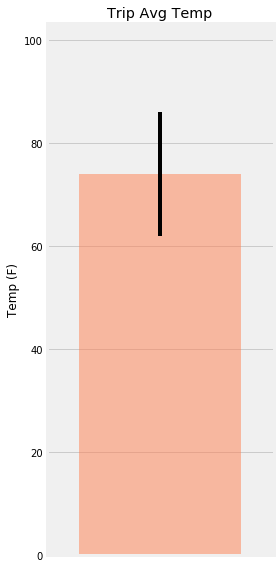

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()


In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2012-01-01'
end_date = '2012-01-07'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
trip_start = '2018-01-01'
trip_end = '2018-01-07'
# Set the start and end date of the trip
trip_dates = pd.date_range(trip_start, trip_end, freq='D')
# Use the start and end date to create a range of dates
trip_month_day = trip_dates.strftime('%m-%d')
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


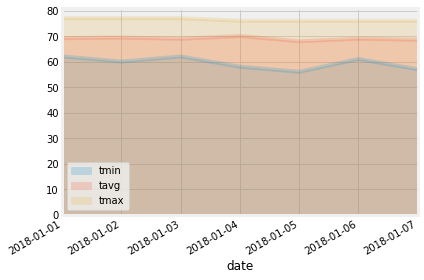

In [39]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()